In [2]:
import modules.network_distance as nd
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import numpy as np
from scipy.signal import find_peaks
import seaborn as sns
sns.set()

# Calculating the Generalized Euclidian Distances

For doing the calculations we need the following inputs

- for timestep t, node attribute dict ```<node id : float>```
- for timestep t+1, node attribute dict ```<node id : float>```
- nx graph object containing the topology of the network (static)

## Aggregating the COVID-19 data by week

First, we load in the official COVID-19 surveillance time series data. This data is updated daily, and can be found [here](https://covid19.ssi.dk/overvagningsdata/download-fil-med-overvaagningdata).

The data I am using contains daily data points from May 6th 2020 up until and including March 7th 2021.

I aggregate the data by week, so as not to accidentally model any recurring weekly patterns, e.g. people not getting tested as much on weekends.

In [3]:
file = 'data/Data-Epidemiologiske-Rapport-22032021/Municipality_cases_time_series.csv'
covid = pd.read_csv(file, delimiter= ';')

covid['SampleDate'] = pd.to_datetime(covid['SampleDate'],format='%Y-%m-%d')
covid = covid[~(covid['SampleDate'] < '2020-05-06')]
covid = covid[~(covid['SampleDate'] > '2021-03-07')]
covid = covid.drop(['NA'], axis=1)
covid = covid.rename(columns={'Copenhagen': 'København'})

covid = covid.resample('W', on='SampleDate').sum()
covid

,Roskilde,København,Aarhus,Frederiksberg,Kalundborg,Middelfart,Gentofte,Solrød,Allerød,Dragør,...,Langeland,Ringsted,Struer,Brønderslev,Hedensted,Varde,Læsø,Ærø,Fanø,Samsø
SampleDate,,,,,,,,,,,,,,,,,,,,,
2020-05-10,14,87,9,20,0,0,12,0,1,1,...,0,6,0,0,0,0,0,0,0,0
2020-05-17,11,83,10,12,6,0,6,1,1,0,...,0,4,0,0,1,2,0,2,0,0
2020-05-24,14,84,5,7,2,0,4,2,1,0,...,0,3,1,1,2,0,0,0,0,0
2020-05-31,4,53,4,1,0,0,4,8,2,1,...,0,2,0,2,0,0,0,0,1,0
2020-06-07,4,36,7,5,0,0,4,12,0,0,...,0,2,0,0,0,0,0,0,0,0
2020-06-14,7,54,5,9,1,0,1,9,1,0,...,0,1,0,0,0,1,0,0,0,0
2020-06-21,6,61,8,11,0,0,11,4,1,0,...,0,1,1,2,0,0,0,0,0,0
2020-06-28,1,37,12,5,0,0,3,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2020-07-05,1,35,3,4,0,0,5,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [4]:
total = covid.sum(axis=1).values.tolist()

Next, I normalize these numbers of positive tests by the population sizes of each municipality.  

I use the official metric for incidence used by SSI, which is, for each municipality, the number of confirmed COVID-19 cases (positive tests) divided by the population size, multiplied by 100,000.

$incidence = \frac{COVID-19\_positives}{population\_size} * 100,000$

I am using the population size as it is recorded in the SSI data set. 

In [5]:
pop = pickle.load(open('data/population.pickle', 'rb'))

covid_norm = covid.copy(deep=True)

for muni in pop.keys():
    covid_norm[muni] = covid_norm[muni].apply(lambda x: (x / pop[muni]) * 100000)

covid_norm.to_pickle('data/covid_norm_weekly.pickle')
covid_norm

,Roskilde,København,Aarhus,Frederiksberg,Kalundborg,Middelfart,Gentofte,Solrød,Allerød,Dragør,...,Langeland,Ringsted,Struer,Brønderslev,Hedensted,Varde,Læsø,Ærø,Fanø,Samsø
SampleDate,,,,,,,,,,,,,,,,,,,,,
2020-05-10,15.924654,13.758421,2.571553,19.174536,0.000000,0.000000,16.036349,0.000000,3.901221,6.899407,...,0.000000,17.215655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-17,12.512228,13.125850,2.857282,11.504722,12.387480,0.000000,8.018175,4.300151,3.901221,0.000000,...,0.000000,11.477103,0.000000,0.000000,2.140319,4.003122,0.000000,33.534541,0.000000,0.000000
2020-05-24,15.924654,13.283993,1.428641,6.711088,4.129160,0.000000,5.345450,8.600301,3.901221,0.000000,...,0.000000,8.607827,4.753755,2.754517,4.280639,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-31,4.549901,8.381567,1.142913,0.958727,0.000000,0.000000,5.345450,34.401204,7.802442,6.899407,...,0.000000,5.738552,0.000000,5.509035,0.000000,0.000000,0.000000,0.000000,28.669725,0.000000
2020-06-07,4.549901,5.693140,2.000097,4.793634,0.000000,0.000000,5.345450,51.601806,0.000000,0.000000,...,0.000000,5.738552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-14,7.962327,8.539710,1.428641,8.628541,2.064580,0.000000,1.336362,38.701355,3.901221,0.000000,...,0.000000,2.869276,0.000000,0.000000,0.000000,2.001561,0.000000,0.000000,0.000000,0.000000
2020-06-21,6.824852,9.646709,2.285825,10.545995,0.000000,0.000000,14.699987,17.200602,3.901221,0.000000,...,0.000000,2.869276,4.753755,5.509035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-28,1.137475,5.851283,3.428738,4.793634,0.000000,0.000000,4.009087,0.000000,0.000000,0.000000,...,8.005764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-05,1.137475,5.534997,0.857184,3.834907,0.000000,0.000000,6.681812,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.754517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Getting all the values as a list of lists because pandas is awful.

In [6]:
idx = covid.index.tolist()

Making the dictionary containing the node weights (which is people tested positive per municipality normalized by that municipality's population size) in the format ``{municipality (str): weight (float)}``.  

This is done for each time step, so the final result is a dictionary of dictionaries:  
``{timestep (int): {municipality1: weight1, ..., municipalityN: weightN} }``. 

In [12]:
def time_series(df):
    vals = df.values.tolist()
    cols = df.columns.tolist()

    time_series = {}

    for timestep, week in enumerate(vals):
        time_series[timestep] = {}
        for muni, data in zip(cols, vals[timestep]):
            time_series[timestep][muni] = data

    print('Weeks of data:', len(time_series))
    print('Data points per week:', len(time_series[0]))
    
    return time_series

pickle.dump(time_series(covid_norm), open('data/time_series.pickle', 'wb'))

Weeks of data: 44
Data points per week: 98


# Finally calculating the GEDs...

I can finally load in my network topology and do the calculations for each timestep.  

I do this using three different methods of normalisation for the node vectors:
1. Normalised so all activation states sum to 1 per vector.
2. Normalised pointwise by individual municipality population size.
3. Normalised using both method 1 AND 2.

In [13]:
def GED(df, norm=False):
    topology = nx.read_gpickle('networks/final_topology.gpickle')
    time = time_series(df)
    distances = []
    for t in range(len(time)-1):
        if norm == False:
            ge = nd.ge(time[t], time[t+1], topology, normed=False)
            distances.append(ge)
        else:
            ge = nd.ge(time[t], time[t+1], topology, normed=True)
            distances.append(ge)
    return distances

In [17]:
distances_sum1 = GED(covid, norm=True) #normalised all attr to sum to 1 NO pop size!
distances_double = GED(covid_norm, norm=True) #normalised all attr to sum to 1 AND by pop size
distances = GED(covid_norm) # normalised all attr only by pop size

distances_double_indexed = [n / max(distances_double) for n in distances_double]
distances_indexed = [n / max(distances) for n in distances]
distances_sum1_indexed = [n / max(distances_sum1) for n in distances_sum1]

weeks = [i for i in range(len(idx))]

Weeks of data: 44
Data points per week: 98
Weeks of data: 44
Data points per week: 98
Weeks of data: 44
Data points per week: 98


## Plotting the results for the different methods of normalisation

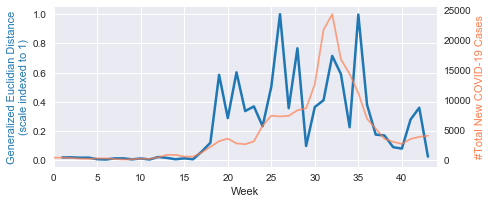

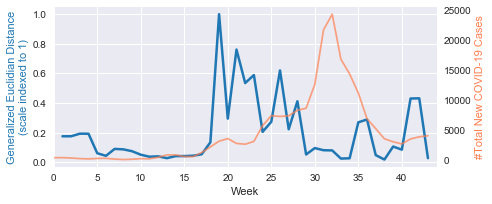

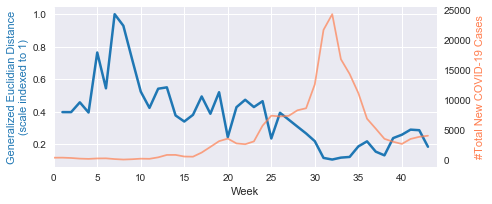

In [18]:
import seaborn as sns
sns.set()

fig, ax1 = plt.subplots(1, figsize=(7,3))#, dpi=400)

color = 'tab:blue'
ax1.set_xlabel('Week')
ax1.set_ylabel('Generalized Euclidian Distance\n(scale indexed to 1)', color=color)
ax1.plot(weeks[1:], distances_indexed, color=color, lw=2.5)
ax1.tick_params(axis='y')
ax1.set_xlim(0,44)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax2 = ax1.twinx()

color = 'coral'
ax2.set_ylabel('#Total New COVID-19 Cases', color=color)
ax2.plot(weeks, total, color='coral', alpha=0.7, label='Total')
ax2.grid(axis='y')

fig.tight_layout()
#plt.savefig('visualisations/GED_popnorm.jpg')
plt.show()

fig, ax3 = plt.subplots(1, figsize=(7,3))#, dpi=400)

color = 'tab:blue'
ax3.set_xlabel('Week')
ax3.set_ylabel('Generalized Euclidian Distance\n(scale indexed to 1)', color=color)
ax3.plot(weeks[1:], distances_double_indexed, color=color, lw=2.5)
ax3.tick_params(axis='y')
ax3.set_xlim(0,44)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax3.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax4 = ax3.twinx()

color = 'coral'
ax4.set_ylabel('#Total New COVID-19 Cases', color=color)
ax4.plot(weeks, total, color='coral', alpha=0.7, label='Total')
ax4.grid(axis='y')

fig.tight_layout()
#plt.savefig('visualisations/GED_doublenorm.jpg')
plt.show()


fig, ax5 = plt.subplots(1, figsize=(7,3))#, dpi=400)

color = 'tab:blue'
ax5.set_xlabel('Week')
ax5.set_ylabel('Generalized Euclidian Distance\n(scale indexed to 1)', color=color)
ax5.plot(weeks[1:], distances_sum1_indexed, color=color, lw=2.5)
ax5.tick_params(axis='y')
ax5.set_xlim(0,44)
ax5.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax5.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax6 = ax5.twinx()

color = 'coral'
ax6.set_ylabel('#Total New COVID-19 Cases', color=color)
ax6.plot(weeks, total, color='coral', alpha=0.7)
ax6.grid(axis='y')

fig.tight_layout()
#plt.savefig('visualisations/GED_sum1norm.jpg')
plt.show()

# Visualising the GED over time

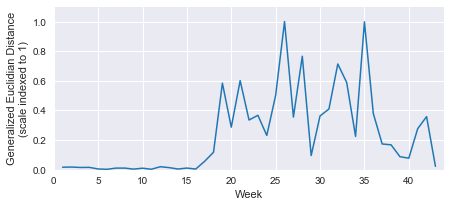

In [90]:
fig, ax = plt.subplots(1, figsize=(7,3))#, dpi=400)

color = 'tab:blue'
ax.set_xlabel('Week')
ax.set_ylabel('Generalized Euclidian Distance\n(scale indexed to 1)')
ax.plot(weeks[1:], distances_indexed, color=color, lw=1.5)
ax.set_xlim(0,44)
ax.set_ylim(0,1.1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.savefig('visualisations/GED.jpg', bbox_inches = "tight")
plt.show()

Finding the dates of the peaks for plotting

In [20]:
peaks, _ = find_peaks(total)
peaky = []
peakx = []

for y in peaks:
    peaky.append(total[y])
    peakx.append(weeks[y])
    
dpeaks, _ = find_peaks(distances)
dpeaky = []
dpeakx = []

for y in dpeaks:
    dpeaky.append(distances[y])
    dpeakx.append(weeks[y+1])
    
print(dpeaks)
print(peaks)

print('Peak 20: ', distances_indexed[19:21])
print('Peak 25: ', distances_indexed[24:26])
print('Peak 32: ', distances_indexed[31:33])

[ 1  3  7  9 11 14 18 20 22 25 27 31 34 41]
[ 1  6 10 14 20 25 32]
Peak 20:  [0.2874936090890832, 0.6012400446648545]
Peak 25:  [0.5026269493382668, 1.0]
Peak 32:  [0.7137135930532408, 0.5894053431636512]


## Plotting the GED with the peaks in total marked

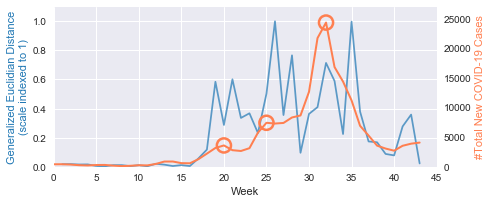

In [21]:
fig, ax1 = plt.subplots(1, figsize=(7,3))#, dpi=400)

color = 'tab:blue'
ax1.set_ylim(0,1.1)
ax1.set_xlabel('Week')
ax1.set_ylabel('Generalized Euclidian Distance\n(scale indexed to 1)', color=color)
ax1.plot(weeks[1:], distances_indexed, color=color, alpha=0.7)
#ax1.scatter(dpeakx[11:13], dpeaky[11:13], marker='o', s=200, facecolors='none', edgecolors=color, lw=3, zorder=1)
ax1.tick_params(axis='y')
ax1.set_xlim(0,45)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'coral'
ax2.set_ylabel('#Total New COVID-19 Cases', color=color)
ax2.plot(weeks, total, color='coral', label='Total',lw=2, zorder=2)
ax2.scatter(peakx[-3:], peaky[-3:], marker='o', s=200, facecolors='none', edgecolors=color, lw=2.5, zorder=2)
ax2.set_ylim(0,27000)
ax2.grid(None)

fig.tight_layout()
#plt.savefig('visualisations/peaks.jpg')
plt.show()